# Fidelity-based quality assessment

Author:  Daniel Proaño-Guevara

PRODEB

### Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
import copy
import pickle

import preprocessing_lib as pplib
import feature_extraction_lib as ftelib

Constants

In [2]:
AVERAGE_WINDOW = 3
SIGNAL_IDX = 238
EXTEND_WINDOW = 8
LAMBDA_PENALTY = 0.5

## Initial signals with their segmentation-delineation

## Phonocardiography (PCG)

ULSGE Dataset

In [3]:
root_dir = r'..\DatasetCHVNGE\pcg_ulsge.pkl'
pcg_df_original = pd.read_pickle(root_dir)
# Deep copy
pcg_df = copy.deepcopy(pcg_df_original)
# Resample them to 50 Hz
pcg_df['PCG'] = pcg_df['PCG'].apply(
    lambda data: pplib.downsample(data, 3000, 1000))

# Import Predictions
pred_path = r'..\ulsge_pcg_pred.pkl'
with open(pred_path, 'rb') as file:
    pcg_predictions = pickle.load(file)

### Smooth Predictions

In [4]:
pcg_processed_predictions = [
    np.column_stack([pplib.moving_average(data[:, i], AVERAGE_WINDOW)
                    for i in range(4)])
    for data in pcg_predictions
]

### Reverse One-hot encoding

Max temporal Sequencing

In [5]:
def max_temporal_modelling(seq, num_states=4):
    for t in range(1, len(seq)):
        if seq[t] != seq[t-1] and seq[t] != ((seq[t-1] + 1) % num_states):
            seq[t] = seq[t-1]
    return seq

In [6]:
pcg_pred_labels = [ftelib.reverse_one_hot_encoding(
    pred) for pred in pcg_processed_predictions]
pcg_prediction_labels = copy.deepcopy(pcg_pred_labels)
pcg_state_predictions = np.array(
    [max_temporal_modelling(prediction) for prediction in pcg_prediction_labels], dtype=object)

## Electrocardiography (ECG)

In [7]:
root_dir = r'..\DatasetCHVNGE\ecg_ulsge.pkl'
ecg_df_original = pd.read_pickle(root_dir)
# Deep copy
ecg_df = copy.deepcopy(ecg_df_original)
# Resample them to 50 Hz
ecg_df['ECG'] = ecg_df['ECG'].apply(
    lambda data: pplib.upsample(data, 500, 1000))
# Import Predictions
predictions_pickle_path = r'..\ulsge_ecg_pred.pkl'
with open(predictions_pickle_path, 'rb') as file:
    ecg_predictions = pickle.load(file)

### Smooth Predictions

In [8]:
ecg_processed_predictions = [
    np.column_stack([pplib.moving_average(data[:, i], AVERAGE_WINDOW)
                    for i in range(4)])
    for data in ecg_predictions
]

### Reverse One-hot encoding

In [9]:
ecg_pred_labels = [ftelib.reverse_one_hot_encoding(
    pred, desired_order=[1, 3, 0, 2]) for pred in ecg_processed_predictions]
ecg_prediction_labels = copy.deepcopy(ecg_pred_labels)
ecg_state_predictions = np.array(
    [prediction for prediction in ecg_prediction_labels], dtype=object)

## ECG and PCG Overlapping

### Raw signals overlapping

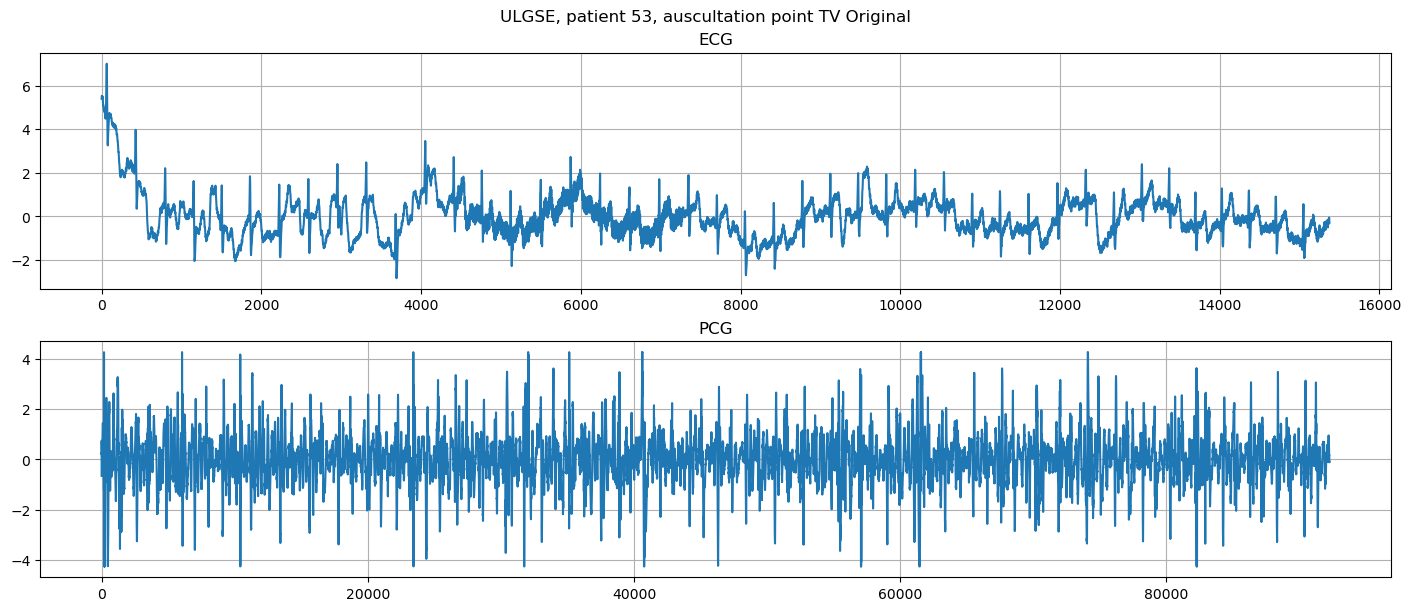

In [15]:
fig, ax = plt.subplots(2, 1, layout='constrained', figsize=(14, 6))
fig.suptitle(
    f"ULGSE, patient {ecg_df['ID'][SIGNAL_IDX]}, auscultation point {ecg_df['Auscultation_Point'][SIGNAL_IDX]} Original")

ax[0].set_title('ECG')
ax[0].plot(ecg_df_original['ECG'][SIGNAL_IDX])
ax[0].grid()

ax[1].set_title('PCG')
ax[1].plot(pcg_df_original['PCG'][SIGNAL_IDX])
ax[1].grid()

plt.show()

### General Analysis

C:\Users\danie\AppData\Local\Temp\ipykernel_12088\17807717.py:41: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


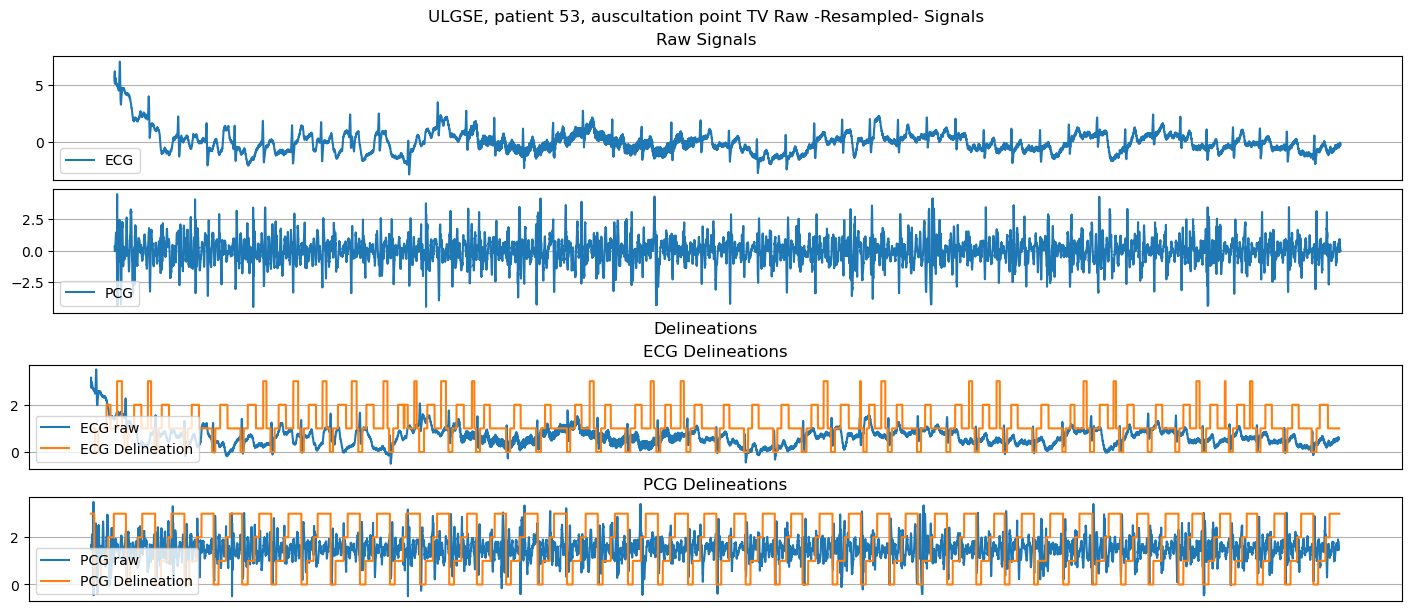

In [16]:
fig = plt.figure(layout='constrained',figsize=(14, 6))
fig.suptitle(
    f"ULGSE, patient {ecg_df['ID'][SIGNAL_IDX]}, auscultation point {ecg_df['Auscultation_Point'][SIGNAL_IDX]} Raw -Resampled- Signals")

subfigs = fig.subfigures(2, 1, hspace=0)

top = subfigs[0].subplots(2, 1, sharex=True)
subfigs[0].suptitle('Raw Signals')
top[0].plot(ecg_df['ECG'][SIGNAL_IDX], label='ECG')
top[0].set_xticks([])
top[0].legend(loc=3)
top[0].grid()

top[1].plot(pcg_df['PCG'][SIGNAL_IDX], label='PCG')
top[1].set_xticks([])
top[1].legend(loc=3)
top[1].grid()


bot = subfigs[1].subplots(2, 1, sharex=True)
subfigs[1].suptitle('Delineations')

bot[0].set_title('ECG Delineations')
bot[0].plot((pplib.min_max_norm2(
    ecg_df['ECG'][SIGNAL_IDX])*2 + 1.5), label='ECG raw')
bot[0].plot(pplib.resample_delineation(
    ecg_state_predictions[SIGNAL_IDX], 50, 1000), label='ECG Delineation')
bot[0].set_xticks([])
bot[0].legend(loc=3)
bot[0].grid()

bot[1].set_title('PCG Delineations')
bot[1].plot((pplib.min_max_norm2(
    pcg_df['PCG'][SIGNAL_IDX])*2 + 1.5), label='PCG raw')
bot[1].plot(pplib.resample_delineation(
    pcg_state_predictions[SIGNAL_IDX], 50, 1000), label='PCG Delineation')
bot[1].set_xticks([])
bot[1].legend(loc=3)
bot[1].grid()

fig.show()

### Sequences Overlap

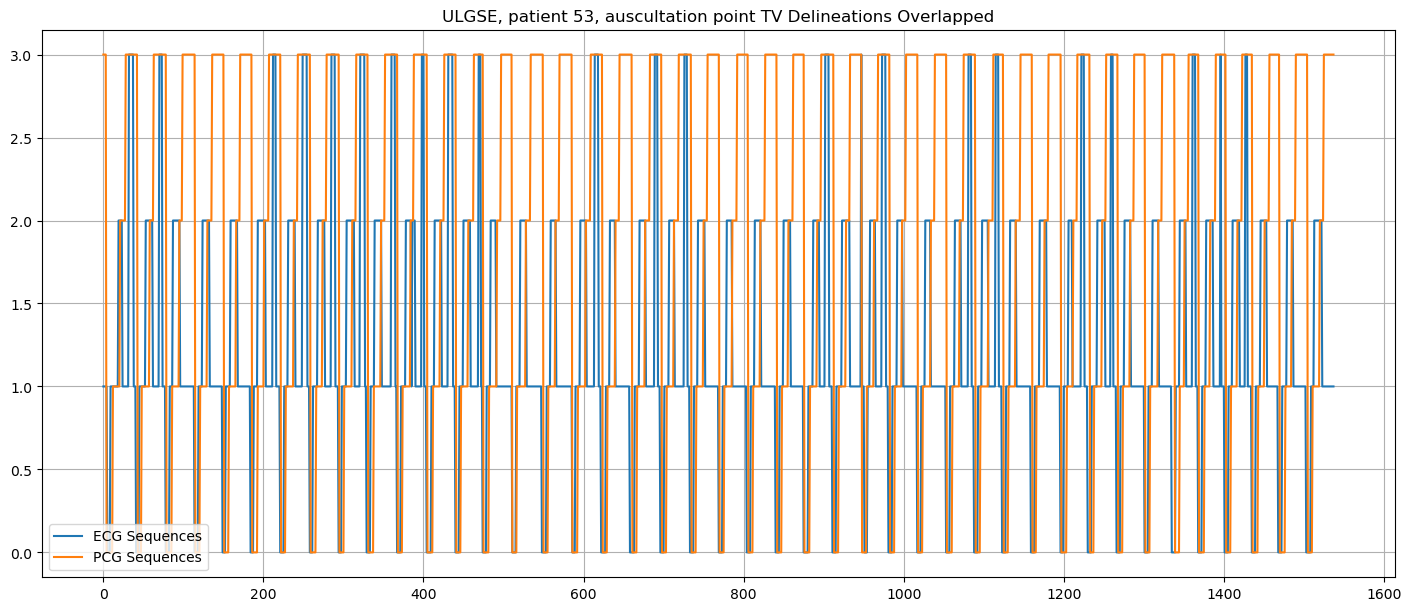

In [17]:
plt.figure(layout='constrained',figsize=(14, 6))
plt.title(
    f"ULGSE, patient {ecg_df['ID'][SIGNAL_IDX]}, auscultation point {ecg_df['Auscultation_Point'][SIGNAL_IDX]} Delineations Overlapped")
plt.plot(ecg_state_predictions[SIGNAL_IDX], label='ECG Sequences')
plt.plot(pcg_state_predictions[SIGNAL_IDX], label='PCG Sequences')
plt.legend(loc=3)
plt.grid()
plt.show()

# Experiment 1: Align delineations and match count (counts presence, not number of points)

In [16]:
ecg_signal = ecg_state_predictions[SIGNAL_IDX]
pcg_signal = pcg_state_predictions[SIGNAL_IDX]
min_duration = 1
min_overlap = 1

### Cardiac Rhythm calculation based on ECG

In [17]:
r_count = ftelib.count_segments(ecg_signal, 0)
cardiac_rhythm_r = ftelib.calculate_bpm(r_count, len(ecg_signal))

print("Cardiac Rhythm based on QRS count: ", cardiac_rhythm_r)

Cardiac Rhythm based on QRS count:  70.22106631989597


In [18]:
t_count = ftelib.count_segments(ecg_signal, 2)
cardiac_rhythm_t = ftelib.calculate_bpm(t_count, len(ecg_signal))

print("Cardiac Rhythm based on t-wave count: ", cardiac_rhythm_t)

Cardiac Rhythm based on t-wave count:  70.22106631989597


### Cardiac Rhythm calculation based on PCG

In [19]:
s1_count = ftelib.count_segments(pcg_signal, 0)
cardiac_rhythm_s1 = ftelib.calculate_bpm(s1_count, len(pcg_signal))

print("Cardiac Rhythm based on S1 count: ", cardiac_rhythm_s1)

Cardiac Rhythm based on S1 count:  70.22106631989597


In [20]:
s2_count = ftelib.count_segments(pcg_signal, 2)
cardiac_rhythm_s2 = ftelib.calculate_bpm(s2_count, len(pcg_signal))

print("Cardiac Rhythm based on S2 count: ", cardiac_rhythm_s2)

Cardiac Rhythm based on S2 count:  70.22106631989597


### Median Heart Rhythm

In [21]:
median_heart_rhythm = np.median(
    [cardiac_rhythm_r, cardiac_rhythm_t, cardiac_rhythm_s1, cardiac_rhythm_s2])
print("Median Cardiac Rhythm [ppm]: ", median_heart_rhythm)

Median Cardiac Rhythm [ppm]:  70.22106631989597


## 1 Count up matches (window overlapping counting)

Count the number of window matches between ECG and PCG

In [22]:
# Extract intervals from the delineation sequences

def get_intervals(signal, target_label, min_duration=1):
    """
    Extract intervals (start, end indices) where signal == target_label.
    Only intervals with duration >= min_duration are returned.
    """
    intervals = []
    in_interval = False
    start = None
    for i, val in enumerate(signal):
        if val == target_label and not in_interval:
            in_interval = True
            start = i
        elif val != target_label and in_interval:
            end = i  # end is the first index where value changes
            if (end - start) >= min_duration:
                intervals.append((start, end))
            in_interval = False
    # If the signal ends while still in an interval:
    if in_interval and (len(signal) - start) >= min_duration:
        intervals.append((start, len(signal)))
    return intervals

In [23]:
# If the intervals match in at least one point, the overlap time is presented

def compute_overlap(interval_a, interval_b):
    """
    Compute the overlap between two intervals.
    Each interval is a tuple (start, end).
    """
    start_a, end_a = interval_a
    start_b, end_b = interval_b
    overlap = max(0, min(end_a, end_b) - max(start_a, start_b))
    return overlap


In [24]:
def match_intervals(ref_intervals, test_intervals, min_overlap=1):
    """
    For each reference interval, check if there is any test interval with
    at least min_overlap samples overlapping.
    Returns the number of matches.
    """
    matches = 0
    for ref in ref_intervals:
        matched = False
        for test in test_intervals:
            if compute_overlap(ref, test) >= min_overlap:
                matched = True
                break
        if matched:
            matches += 1
    return matches

**Individual Analysis Constants**

In [ ]:
SIGNAL_IDX = 238
EXTEND_WINDOW = 8
LAMBDA_PENALTY = 0.5

In [26]:
# Extract intervals for physiologically valid segments
ecg_qrs = get_intervals(ecg_signal, target_label=0, min_duration=min_duration)
ecg_twave = get_intervals(ecg_signal, target_label=2,
                          min_duration=min_duration)
pcg_s1 = get_intervals(pcg_signal, target_label=0, min_duration=min_duration)
pcg_s2 = get_intervals(pcg_signal, target_label=2, min_duration=min_duration)

## ECG-to-PCG Analysis

In [27]:
# Extend to the right ECG segments
qrs_extended = pplib.extend_intervals(ecg_qrs, 'right', EXTEND_WINDOW)
twave_extended = pplib.extend_intervals(ecg_twave, 'right', EXTEND_WINDOW)

### Linear combination strategy

In [28]:
match_qrs = match_intervals(qrs_extended, pcg_s1, min_overlap=min_overlap)
match_twave = match_intervals(twave_extended, pcg_s2, min_overlap=min_overlap)

# QRS should match with S1, T-wave should match with S2
total_ecg = len(ecg_qrs) + len(ecg_twave)
matches_ecg = match_qrs + match_twave
# Apply linear penalty for missing matches
score_ecg_to_pcg = (matches_ecg - LAMBDA_PENALTY *
                    (total_ecg - matches_ecg)) / total_ecg if total_ecg > 0 else 0

print('Linear combination of metrics E2P: ', score_ecg_to_pcg)

Linear combination of metrics E2P:  1.0


### Metrics-Minima Strategy

In [29]:
# Compute score for QRS: if no QRS intervals, assume worst match (score = 0)
if len(qrs_extended) > 0:
    score_qrs = (match_qrs - LAMBDA_PENALTY *
                 (len(ecg_qrs) - match_qrs)) / len(ecg_qrs)
else:
    score_qrs = 0

# Compute score for T-wave: if no T-wave intervals, assume worst match (score = 0)
if len(twave_extended) > 0:
    score_twave = (match_twave - LAMBDA_PENALTY *
                   (len(ecg_twave) - match_twave)) / len(ecg_twave)
else:
    score_twave = 0

# Overall ECG-to-PCG score is the minimum of the two scores to ensure both segments align well
score_ecg_to_pcg = min(score_qrs, score_twave)

print('Minimum-based metrics E2P: ', score_ecg_to_pcg)

Minimum-based metrics E2P:  1.0


## PCG-to-ECG Analysis

In [30]:
# Extend PCG segments to the left
s1_extended = pplib.extend_intervals(pcg_s1, 'left', EXTEND_WINDOW)
s2_extended = pplib.extend_intervals(pcg_s2, 'left', EXTEND_WINDOW)

### Linear Combination

In [31]:
match_s1 = match_intervals(s1_extended, ecg_qrs, min_overlap=min_overlap)
match_s2 = match_intervals(s2_extended, ecg_twave, min_overlap=min_overlap)
# QRS should match with S1, T-wave should match with S2
total_pcg = len(pcg_s1) + len(pcg_s2)
matches_pcg = match_s1 + match_s2
score_pcg_to_ecg = (matches_pcg - LAMBDA_PENALTY *
                    (total_pcg - matches_pcg)) / total_pcg if total_pcg > 0 else 0
print('Linear combination of metrics P2E: ', score_pcg_to_ecg)

Linear combination of metrics P2E:  1.0


### Metrics-Minima Strategy

In [32]:
# Compute score for S1: if no S1 intervals, assume worst match (score = 0)
if len(s1_extended) > 0:
    score_s1 = (match_s1 - LAMBDA_PENALTY *
                (len(pcg_s1) - match_s1)) / len(pcg_s1)
else:
    score_s1 = 0

# Compute score for S2: if no S2 intervals, assume worst match (score = 0)
if len(s2_extended) > 0:
    score_s2 = (match_s2 - LAMBDA_PENALTY *
                (len(pcg_s2) - match_s2)) / len(pcg_s2)
else:
    score_s2 = 0

# Overall PCG-to-ECG score is the minimum of the two scores to ensure both segments align well
score_pcg_to_ecg = min(score_s1, score_s2)

print('Minimum-based metrics P2E: ', score_pcg_to_ecg)

Minimum-based metrics P2E:  1.0


## Form functions for strategy

In [33]:
def alignment_metric_min_lin(ecg_signal, pcg_signal, lambda_penalty=0.5, min_duration=1, min_overlap=1, extend_window=8):
    """
    Compute the bidirectional alignment metric for the fiducial segments.
    Assumes:
      - ECG: QRS (0) and T-wave (2)
      - PCG: S1 (0) and S2 (2)
    Returns the overall metric and individual directional scores.
    """
    # Extract intervals for physiologically valid segments
    ecg_qrs = get_intervals(ecg_signal, target_label=0, min_duration=min_duration)
    ecg_twave = get_intervals(ecg_signal, target_label=2, min_duration=min_duration)
    pcg_s1 = get_intervals(pcg_signal, target_label=0, min_duration=min_duration)
    pcg_s2 = get_intervals(pcg_signal, target_label=2, min_duration=min_duration)
    
    # ECG-to-PCG matching
    # Extend to the right ECG segments
    qrs_extended = pplib.extend_intervals(ecg_qrs, 'right', extend_window)
    twave_extended = pplib.extend_intervals(ecg_twave, 'right', extend_window)
    match_qrs = match_intervals(qrs_extended, pcg_s1, min_overlap=min_overlap)
    match_twave = match_intervals(twave_extended, pcg_s2, min_overlap=min_overlap)
    # QRS should match with S1, T-wave should match with S2
    total_ecg = len(ecg_qrs) + len(ecg_twave)
    matches_ecg = match_qrs + match_twave
    # Apply linear penalty for missing matches
    score_ecg_to_pcg = (matches_ecg - lambda_penalty * (total_ecg - matches_ecg)) / total_ecg if total_ecg > 0 else 0

    # PCG-to-ECG matching
    # Extend PCG segments to the left
    s1_extended = pplib.extend_intervals(pcg_s1, 'left', extend_window)
    s2_extended = pplib.extend_intervals(pcg_s2, 'left', extend_window)
    match_s1 = match_intervals(s1_extended, ecg_qrs, min_overlap=min_overlap)
    match_s2 = match_intervals(s2_extended, ecg_twave, min_overlap=min_overlap)
    # S1 should match with QRS, S2 should match with T-wave
    total_pcg = len(pcg_s1) + len(pcg_s2)
    matches_pcg = match_s1 + match_s2
    score_pcg_to_ecg = (matches_pcg - lambda_penalty * (total_pcg - matches_pcg)) / total_pcg if total_pcg > 0 else 0

    # Overall metric is the minima of both directional scores
    overall_metric = min(score_ecg_to_pcg, score_pcg_to_ecg)
    return overall_metric

In [34]:
def alignment_metric_avg_lin(ecg_signal, pcg_signal, lambda_penalty=0.5, min_duration=1, min_overlap=1, extend_window=8):
    """
    Compute the bidirectional alignment metric for the fiducial segments.
    Assumes:
      - ECG: QRS (0) and T-wave (2)
      - PCG: S1 (0) and S2 (2)
    Returns the overall metric and individual directional scores.
    """
    # Extract intervals for physiologically valid segments
    ecg_qrs = get_intervals(ecg_signal, target_label=0, min_duration=min_duration)
    ecg_twave = get_intervals(ecg_signal, target_label=2, min_duration=min_duration)
    pcg_s1 = get_intervals(pcg_signal, target_label=0, min_duration=min_duration)
    pcg_s2 = get_intervals(pcg_signal, target_label=2, min_duration=min_duration)
    
    # ECG-to-PCG matching
    # Extend to the right ECG segments
    qrs_extended = pplib.extend_intervals(ecg_qrs, 'right', extend_window)
    twave_extended = pplib.extend_intervals(ecg_twave, 'right', extend_window)
    match_qrs = match_intervals(qrs_extended, pcg_s1, min_overlap=min_overlap)
    match_twave = match_intervals(twave_extended, pcg_s2, min_overlap=min_overlap)
    # QRS should match with S1, T-wave should match with S2
    total_ecg = len(ecg_qrs) + len(ecg_twave)
    matches_ecg = match_qrs + match_twave
    # Apply linear penalty for missing matches
    score_ecg_to_pcg = (matches_ecg - lambda_penalty * (total_ecg - matches_ecg)) / total_ecg if total_ecg > 0 else 0

    # PCG-to-ECG matching
    # Extend PCG segments to the left
    s1_extended = pplib.extend_intervals(pcg_s1, 'left', extend_window)
    s2_extended = pplib.extend_intervals(pcg_s2, 'left', extend_window)
    match_s1 = match_intervals(s1_extended, ecg_qrs, min_overlap=min_overlap)
    match_s2 = match_intervals(s2_extended, ecg_twave, min_overlap=min_overlap)
    # S1 should match with QRS, S2 should match with T-wave
    total_pcg = len(pcg_s1) + len(pcg_s2)
    matches_pcg = match_s1 + match_s2
    score_pcg_to_ecg = (matches_pcg - lambda_penalty * (total_pcg - matches_pcg)) / total_pcg if total_pcg > 0 else 0

    # Overall metric is the average of both directional scores
    overall_metric = 0.5 * (score_ecg_to_pcg + score_pcg_to_ecg)
    return overall_metric

In [35]:
def alignment_metric_min_min(ecg_signal, pcg_signal, lambda_penalty=0.5, min_duration=1, min_overlap=1, extend_window=8):
    """
    Compute the bidirectional alignment metric for the fiducial segments.
    Assumes:
      - ECG: QRS (0) and T-wave (2)
      - PCG: S1 (0) and S2 (2)
    Returns the overall metric and individual directional scores.
    """
    # Extract intervals for physiologically valid segments
    ecg_qrs = get_intervals(ecg_signal, target_label=0, min_duration=min_duration)
    ecg_twave = get_intervals(ecg_signal, target_label=2, min_duration=min_duration)
    pcg_s1 = get_intervals(pcg_signal, target_label=0, min_duration=min_duration)
    pcg_s2 = get_intervals(pcg_signal, target_label=2, min_duration=min_duration)
    
    # ECG-to-PCG matching
    # Extend to the right ECG segments
    qrs_extended = pplib.extend_intervals(ecg_qrs, 'right', extend_window)
    twave_extended = pplib.extend_intervals(ecg_twave, 'right', extend_window)
    match_qrs = match_intervals(qrs_extended, pcg_s1, min_overlap=min_overlap)
    match_twave = match_intervals(twave_extended, pcg_s2, min_overlap=min_overlap)
    # QRS should match with S1, T-wave should match with S2
    # Compute score for QRS: if no QRS intervals, assume worst match (score = 0)
    if len(qrs_extended) > 0:
        score_qrs = (match_qrs - lambda_penalty *
                    (len(ecg_qrs) - match_qrs)) / len(ecg_qrs)
    else:
        score_qrs = 0

    # Compute score for T-wave: if no T-wave intervals, assume worst match (score = 0)
    if len(twave_extended) > 0:
        score_twave = (match_twave - lambda_penalty *
                    (len(ecg_twave) - match_twave)) / len(ecg_twave)
    else:
        score_twave = 0

    # Overall ECG-to-PCG score is the minimum of the two scores to ensure both segments align well
    score_ecg_to_pcg = min(score_qrs, score_twave)

    # PCG-to-ECG matching
    # Extend PCG segments to the left
    s1_extended = pplib.extend_intervals(pcg_s1, 'left', extend_window)
    s2_extended = pplib.extend_intervals(pcg_s2, 'left', extend_window)
    match_s1 = match_intervals(s1_extended, ecg_qrs, min_overlap=min_overlap)
    match_s2 = match_intervals(s2_extended, ecg_twave, min_overlap=min_overlap)
    # S1 should match with QRS, S2 should match with T-wave
    # Compute score for S1: if no S1 intervals, assume worst match (score = 0)
    if len(s1_extended) > 0:
        score_s1 = (match_s1 - lambda_penalty *
                    (len(pcg_s1) - match_s1)) / len(pcg_s1)
    else:
        score_s1 = 0

    # Compute score for S2: if no S2 intervals, assume worst match (score = 0)
    if len(s2_extended) > 0:
        score_s2 = (match_s2 - lambda_penalty *
                    (len(pcg_s2) - match_s2)) / len(pcg_s2)
    else:
        score_s2 = 0

    # Overall PCG-to-ECG score is the minimum of the two scores to ensure both segments align well
    score_pcg_to_ecg = min(score_s1, score_s2)

    # Overall metric is the minima of both directional scores
    overall_metric = min(score_ecg_to_pcg, score_pcg_to_ecg)
    return overall_metric

In [36]:
def alignment_metric_avg_min(ecg_signal, pcg_signal, lambda_penalty=0.5, min_duration=1, min_overlap=1, extend_window=8):
    """
    Compute the bidirectional alignment metric for the fiducial segments.
    Assumes:
      - ECG: QRS (0) and T-wave (2)
      - PCG: S1 (0) and S2 (2)
    Returns the overall metric and individual directional scores.
    """
    # Extract intervals for physiologically valid segments
    ecg_qrs = get_intervals(ecg_signal, target_label=0, min_duration=min_duration)
    ecg_twave = get_intervals(ecg_signal, target_label=2, min_duration=min_duration)
    pcg_s1 = get_intervals(pcg_signal, target_label=0, min_duration=min_duration)
    pcg_s2 = get_intervals(pcg_signal, target_label=2, min_duration=min_duration)
    
    # ECG-to-PCG matching
    # Extend to the right ECG segments
    qrs_extended = pplib.extend_intervals(ecg_qrs, 'right', extend_window)
    twave_extended = pplib.extend_intervals(ecg_twave, 'right', extend_window)
    match_qrs = match_intervals(qrs_extended, pcg_s1, min_overlap=min_overlap)
    match_twave = match_intervals(twave_extended, pcg_s2, min_overlap=min_overlap)
    # QRS should match with S1, T-wave should match with S2
    # Compute score for QRS: if no QRS intervals, assume worst match (score = 0)
    if len(qrs_extended) > 0:
        score_qrs = (match_qrs - lambda_penalty *
                    (len(ecg_qrs) - match_qrs)) / len(ecg_qrs)
    else:
        score_qrs = 0

    # Compute score for T-wave: if no T-wave intervals, assume worst match (score = 0)
    if len(twave_extended) > 0:
        score_twave = (match_twave - lambda_penalty *
                    (len(ecg_twave) - match_twave)) / len(ecg_twave)
    else:
        score_twave = 0

    # Overall ECG-to-PCG score is the minimum of the two scores to ensure both segments align well
    score_ecg_to_pcg = min(score_qrs, score_twave)

    # PCG-to-ECG matching
    # Extend PCG segments to the left
    s1_extended = pplib.extend_intervals(pcg_s1, 'left', extend_window)
    s2_extended = pplib.extend_intervals(pcg_s2, 'left', extend_window)
    match_s1 = match_intervals(s1_extended, ecg_qrs, min_overlap=min_overlap)
    match_s2 = match_intervals(s2_extended, ecg_twave, min_overlap=min_overlap)
    # S1 should match with QRS, S2 should match with T-wave
    # Compute score for S1: if no S1 intervals, assume worst match (score = 0)
    if len(s1_extended) > 0:
        score_s1 = (match_s1 - lambda_penalty *
                    (len(pcg_s1) - match_s1)) / len(pcg_s1)
    else:
        score_s1 = 0

    # Compute score for S2: if no S2 intervals, assume worst match (score = 0)
    if len(s2_extended) > 0:
        score_s2 = (match_s2 - lambda_penalty *
                    (len(pcg_s2) - match_s2)) / len(pcg_s2)
    else:
        score_s2 = 0

    # Overall PCG-to-ECG score is the minimum of the two scores to ensure both segments align well
    score_pcg_to_ecg = min(score_s1, score_s2)

    # Overall metric is the average of both directional scores
    overall_metric = 0.5 * (score_ecg_to_pcg + score_pcg_to_ecg)
    return overall_metric

In [ ]:
SIGNAL_IDX = 238
min_lin_metric = alignment_metric_min_lin(ecg_state_predictions[SIGNAL_IDX], pcg_state_predictions[SIGNAL_IDX])
avg_lin_metric = alignment_metric_avg_lin(ecg_state_predictions[SIGNAL_IDX], pcg_state_predictions[SIGNAL_IDX])
min_min_metric = alignment_metric_min_min(ecg_state_predictions[SIGNAL_IDX], pcg_state_predictions[SIGNAL_IDX])
avg_min_metric = alignment_metric_avg_min(ecg_state_predictions[SIGNAL_IDX], pcg_state_predictions[SIGNAL_IDX])

print(f"ULGSE, patient {ecg_df['ID'][SIGNAL_IDX]}, auscultation point {ecg_df['Auscultation_Point'][SIGNAL_IDX]}" )
print("Minima of Linear combination Metric:", min_lin_metric)
print("Average of Linear combination Metric:", avg_lin_metric)
print("Minima of Minima of directional Metrics:", min_min_metric)
print("Average of Minima of directional Metrics:", avg_min_metric)

ULGSE, patient 100, auscultation point MV
Minima of Linear combination Metric: 1.0
Average of Linear combination Metric: 1.0
Minima of Minima of directional Metrics: 1.0
Average of Minima of directional Metrics: 1.0
